# Hans 2024 data v2

Let's take a look at the perplexity ratio score data generated with the v2 scoring algorithm.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load the scored text fragment data from the Hans 2024 corpus.

In [2]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/falcon-7b_scores_v2.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Source record num               634 non-null    int64  
 1   Fragment length (words)         634 non-null    int64  
 2   Fragment length (tokens)        634 non-null    int64  
 3   Dataset                         634 non-null    object 
 4   Source                          634 non-null    object 
 5   String                          634 non-null    object 
 6   Reversed string                 634 non-null    object 
 7   Perplexity                      634 non-null    float64
 8   Reverse perplexity              634 non-null    float64
 9   Cross-perplexity                634 non-null    float64
 10  Reverse cross-perplexity        634 non-null    float64
 11  Perplexity ratio score          634 non-null    float64
 12  Reverse perplexity ratio score  634 

Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 317 human text fragments and 317 synthetic fragments.
Dataset is 50.0% synthetic fragments.


In [4]:
data_df.head()

,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Reversed string,Perplexity,Reverse perplexity,Cross-perplexity,Reverse cross-perplexity,Perplexity ratio score,Reverse perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)
0,101,37,48,cc_news,synthetic,of the unpaid payroll tax.\nFor more details a...,on based low too tax your calculate sometimes ...,2.834761,6.156763,3.273555,6.375690,0.865958,0.965662,6.440337,6.421124,88.967168,87.709696
1,96,107,147,cc_news,synthetic,not as much as they will one day mean again.\n...,"either players not we're but developers, not w...",2.670562,5.443344,3.238585,5.709815,0.824608,0.953331,14.289257,14.947619,88.967168,87.640064
2,17,199,322,cc_news,human,earnings revised up thanks in part to Washingt...,already has governor bank central Russia’s per...,2.267672,5.134294,2.314948,5.278485,0.979578,0.972683,30.459167,30.424932,91.713536,87.754752
3,169,26,38,cc_news,human,a human cornea. It took less than 10 minutes t...,"Engineering Tissue of Professor Connon, grow.\...",3.943990,6.533620,3.817595,6.284147,1.033108,1.039699,5.914765,5.899320,89.282560,87.640064
4,29,107,158,cc_news,synthetic,"dread, you might be interested in the document...",deliberation much after baby a have to decide ...,2.058805,5.762444,2.718828,5.920505,0.757240,0.973303,16.022920,15.886398,90.433536,87.640064


In [5]:
data_df.tail()

,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Reversed string,Perplexity,Reverse perplexity,Cross-perplexity,Reverse cross-perplexity,Perplexity ratio score,Reverse perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)
629,42,162,222,cc_news,human,A mill nearly as old as Canada must be sold if...,"to love love, love, would then.\n""I since unoc...",2.944409,6.293189,2.897910,6.223848,1.016046,1.011141,21.336297,21.468515,88.967168,87.640064
630,113,235,361,cc_news,synthetic,"said Jake Nelson, the council's director of st...",As longer. road the on staying They're miles. ...,1.849067,4.907613,2.237945,5.314809,0.826234,0.923385,32.502246,33.896739,89.081856,89.672704
631,169,123,180,cc_news,synthetic,"disease, could soon be available for more peop...",Credit: level. next the to evolve to continue ...,2.275110,5.515828,2.595455,5.748359,0.876575,0.959548,17.540479,17.691026,90.613760,87.640064
632,69,117,157,cc_news,human,"has also taken the system, which uses wireless...",we But feedback. monitoring for good really ar...,3.003191,6.038559,2.980378,6.414858,1.007654,0.941339,15.426316,16.010284,88.967168,87.640064
633,71,46,72,cc_news,human,Virtue and A Few Best Men thinks Australians w...,internet the – explosion information the was '...,3.312766,5.694704,3.051363,5.893728,1.085667,0.966231,8.524072,8.374700,89.468928,87.640064


Make some plots with perplexity ratio score and related variables to what we have.

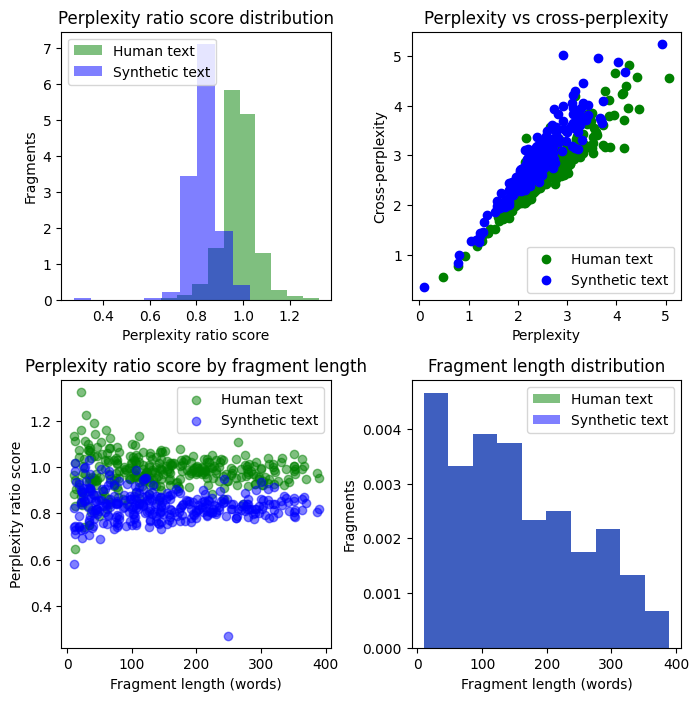

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (words)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (words)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (words)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (words)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (words)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (words)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Same plots as above, but with perplexity values calculated on the reversed text fragments.

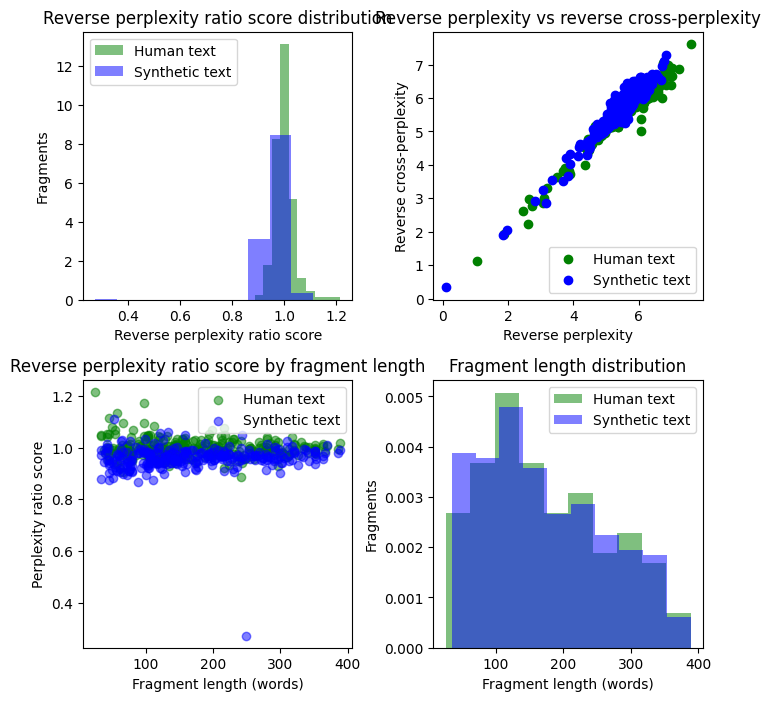

In [19]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Reverse perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Reverse perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Reverse perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Reverse perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Reverse perplexity vs reverse cross-perplexity')
axs[0,1].scatter(human_fragments['Reverse perplexity'], human_fragments['Reverse cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Reverse perplexity'], synthetic_fragments['Reverse cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Reverse perplexity')
axs[0,1].set_ylabel('Reverse cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Reverse perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (words)'], human_fragments['Reverse perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (words)'], synthetic_fragments['Reverse perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (words)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (words)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (words)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (words)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [17]:
# Remove some features we will not use for feature engineering or training
data_df.drop(['Source record num', 'Dataset', 'Reader time (seconds)', 'Writer time (seconds)', 'Reader peak memory (GB)', 'Writer peak memory (GB)'], axis = 1, inplace = True)

training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 442 training examples
Have 110 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Fragment length (words)         110 non-null    int64  
 1   Fragment length (tokens)        110 non-null    int64  
 2   Source                          110 non-null    object 
 3   String                          110 non-null    object 
 4   Reversed string                 110 non-null    object 
 5   Perplexity                      110 non-null    float64
 6   Reverse perplexity              110 non-null    float64
 7   Cross-perplexity                110 non-null    float64
 8   Reverse cross-perplexity        110 non-null    float64
 9   Perplexity ratio score          110 non-null    float64
 10  Reverse perplexity ratio score  110 non-null    float64
dtypes: float64(6), int64(2), object(3)
memory u

And finally, save the split data for future use.

In [18]:
# Save testing data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())